# Submission for Option 2: CLIP-AURA Soccer Player Tracker
## Author: Mihika Usgaonker
## Model Stack: YOLOv11 + CLIP ReID-B/16 + AURA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yolo_best/pytorch/default/1/best.pt
/kaggle/input/clip-reid-repo/clip_reid-master/train.py
/kaggle/input/clip-reid-repo/clip_reid-master/evaluate.py
/kaggle/input/clip-reid-repo/clip_reid-master/LICENSE
/kaggle/input/clip-reid-repo/clip_reid-master/.gitignore
/kaggle/input/clip-reid-repo/clip_reid-master/README.md
/kaggle/input/clip-reid-repo/clip_reid-master/requirements.txt
/kaggle/input/clip-reid-repo/clip_reid-master/download_data.py
/kaggle/input/clip-reid-repo/clip_reid-master/preprocess_data.py
/kaggle/input/clip-reid-repo/clip_reid-master/predict.py
/kaggle/input/clip-reid-repo/clip_reid-master/docs/CLIP-ReIdent.png
/kaggle/input/clip-reid-repo/clip_reid-master/docs/CLIP-ReIdent_Technical_Report.pdf
/kaggle/input/clip-reid-repo/clip_reid-master/clipreid/trainer.py
/kaggle/input/clip-reid-repo/clip_reid-master/clipreid/transforms.py
/kaggle/input/clip-reid-repo/clip_reid-master/clipreid/metrics.py
/kaggle/input/clip-reid-repo/clip_reid-master/clipreid/model.py
/kag

## Setup and Imports

In [2]:
!pip install -q -U ultralytics open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import sys
sys.path.append("/kaggle/input/clip-reid-repo/clip_reid-master")
from clipreid.model import OpenClipModel
from clipreid.transforms import get_transforms

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Model and Video Setup


In [4]:
yolo_path = '/kaggle/input/yolo_best/pytorch/default/1/best.pt'
video_path = '/kaggle/input/15-sec-input/15sec_input_720p.mp4'
clip_weights = "/kaggle/input/clip-reid-b16-checkpoints/weights_e8.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model_yolo = YOLO(yolo_path)
model_clip = OpenClipModel(model_name="ViT-B-16", pretrained="openai", remove_proj=True)
state_dict = torch.load(clip_weights, map_location=device)
if 'model' in state_dict:
    state_dict = state_dict['model']
model_clip.load_state_dict(state_dict, strict=True)
model_clip.eval().to(device)
val_transforms, _ = get_transforms((224, 224))

open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Remove Projection Layer - old output size: 512 - new output size: 768


## Video Loading and Frame Extraction

In [6]:
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames, fps, width, height

frames, fps, width, height = load_video_frames(video_path)
print(f"[INFO] Loaded {len(frames)} frames")

[INFO] Loaded 375 frames


## YOLOv11 Detection

In [7]:
results = list(model_yolo(source=video_path, classes=2, save=False))
frame_detections = []
for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()
    confs = r.boxes.conf.cpu().numpy()
    classes = r.boxes.cls.cpu().numpy()
    frame_detections.append({"boxes": boxes, "confidences": confs, "classes": classes})


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/375) /kaggle/input/15-sec-input/15sec_input_720p.mp4: 384x640 16 players, 82.6ms
video 1/1 (frame 2/375) /kaggle/input/15-sec-input/15sec_input_720p.mp4: 384x640 18 players, 31.9ms
video 1/1 (frame 3/375) /kaggle/input/15-sec-input/15sec_input_720p.mp4: 384x640 16 players, 31.8ms
video 1/1 (frame 4/375) /kaggle/input/15-sec-input/15sec_input_720p.mp4: 384x640 14 players, 31.7ms
video 1/1 (frame 5/375) /kaggle/input/15-sec-input/15sec

## Player Crop Extraction

In [8]:
player_crops = []
flat_crops = []
for frame_idx, det in enumerate(frame_detections):
    frame = frames[frame_idx]
    boxes = det["boxes"]
    crops = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        crop = frame[y1:y2, x1:x2]
        if crop.shape[0] >= 30 and crop.shape[1] >= 30:
            crops.append(crop)
            flat_crops.append(crop)
    player_crops.append(crops)
print(f"[INFO] Total heuristic crops: {len(flat_crops)}")

[INFO] Total heuristic crops: 3905


## CLIP-ReID Feature Extraction

In [9]:
crop_tensors = []
for crop in flat_crops:
    crop_resized = cv2.resize(crop, (224, 224))
    transformed = val_transforms(image=crop_resized)['image']
    crop_tensors.append(transformed)

final_embeddings = []
batch_size = 32
for i in range(0, len(crop_tensors), batch_size):
    batch = torch.stack(crop_tensors[i:i+batch_size]).to(device)
    with torch.no_grad():
        emb = model_clip(batch)
    final_embeddings.append(emb.cpu())
final_embeddings = torch.cat(final_embeddings, dim=0)
print(f"[RESULT] Final embeddings shape: {final_embeddings.shape}")

[RESULT] Final embeddings shape: torch.Size([3905, 768])


## Green Suppression and Jersey Clustering

In [10]:
def is_green(rgb):
    r, g, b = rgb
    return (g > 90) and (g > r + 30) and (g > b + 30)

dominant_colors = []
for crop in flat_crops:
    small = cv2.resize(crop, (50, 50))
    pixels = small.reshape((-1, 3))
    kmeans = KMeans(n_clusters=1, n_init='auto', random_state=42).fit(pixels)
    dom_color = kmeans.cluster_centers_[0]
    dominant_colors.append(dom_color[::-1])  # BGR → RGB
dominant_colors = np.array(dominant_colors)

k = 4
kmeans_jersey = KMeans(n_clusters=k, random_state=42).fit(dominant_colors)
team_labels_raw = kmeans_jersey.labels_
team_centroids = kmeans_jersey.cluster_centers_

suppress_green = False
green_cluster_indices = []
green_cluster_ids = []

for i, centroid in enumerate(team_centroids):
    if is_green(centroid):
        cluster_indices = np.where(team_labels_raw == i)[0]
        green_cluster_indices.extend(cluster_indices)
        green_cluster_ids.append(i)

if green_cluster_indices:
    green_embeddings = final_embeddings[green_cluster_indices]
    green_var = green_embeddings.std().item()
    print(f"[GREEN] Found green cluster(s): {green_cluster_ids}, Var = {green_var:.4f}, Count = {len(green_cluster_indices)}")
    if len(green_cluster_indices) < 60 or green_var > 0.25:
        suppress_green = True
        print("[ACTION] Suppressing green cluster(s).")

mask = np.ones(len(flat_crops), dtype=bool)
if suppress_green:
    mask[green_cluster_indices] = False

filtered_embeddings = final_embeddings[mask]
filtered_labels_raw = team_labels_raw[mask]
unique_clusters = sorted(set(filtered_labels_raw))
team_label_map = {old: new for new, old in enumerate(unique_clusters)}
filtered_labels = [team_label_map[label] for label in filtered_labels_raw]

print(f"[INFO] Final usable embeddings: {len(filtered_embeddings)}")
print(f"[INFO] Team label distribution: {dict(zip(*np.unique(filtered_labels, return_counts=True)))}")


[INFO] Final usable embeddings: 3905
[INFO] Team label distribution: {0: 876, 1: 889, 2: 1313, 3: 827}


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##  PCA Visualization

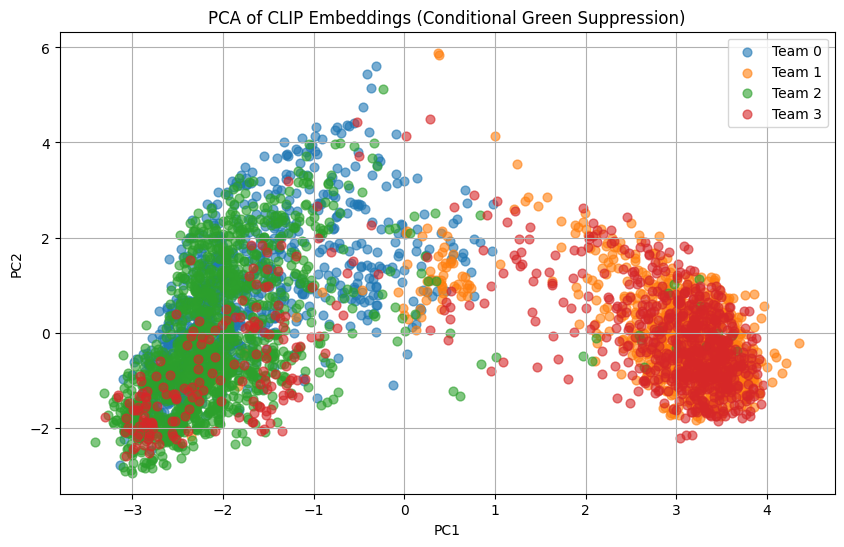

In [11]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(filtered_embeddings.numpy())
plt.figure(figsize=(10, 6))
for team_id in np.unique(filtered_labels):
    mask = (np.array(filtered_labels) == team_id)
    plt.scatter(
        pca_result[mask, 0], pca_result[mask, 1],
        label=f"Team {team_id}", s=40, alpha=0.6
    )
plt.legend()
plt.title("PCA of CLIP Embeddings (Conditional Green Suppression)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## AURA Identity Assignment

In [12]:

memory_bank = {}
frame_id_assignments = []
id_counter = 0
threshold = 0.85
window_size = 50

def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (box1[2] - box1[0]) * (box1[3] - box1[1])
    boxBArea = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

for start in range(0, len(player_crops), window_size):
    end = min(start + window_size, len(player_crops))
    for local_frame_idx in range(start, end):
        frame = local_frame_idx
        crops = player_crops[frame]

        if len(crops) == 0:
            frame_id_assignments.append([])
            continue

        boxes_all = frame_detections[frame]['boxes']
        valid_boxes = []
        crop_to_box_map = []
        for i, box in enumerate(boxes_all):
            x1, y1, x2, y2 = map(int, box)
            if (x2 - x1) >= 30 and (y2 - y1) >= 30:
                valid_boxes.append(box)
                crop_to_box_map.append(i)

        crop_tensors = []
        for crop in crops:
            resized = cv2.resize(crop, (224, 224))
            transformed = val_transforms(image=resized)['image']
            crop_tensors.append(transformed)

        batch = torch.stack(crop_tensors).to(device)
        with torch.no_grad():
            frame_embeddings = model_clip(batch).cpu()

        start_idx = sum(len(pc) for pc in player_crops[:frame])
        team_labels_this_frame = filtered_labels[start_idx:start_idx + len(crops)]

        overlap_groups = []
        used = set()
        for i in range(len(valid_boxes)):
            if i in used:
                continue
            group = [i]
            for j in range(i+1, len(valid_boxes)):
                if compute_iou(valid_boxes[i], valid_boxes[j]) > 0.5:
                    group.append(j)
                    used.add(j)
            used.update(group)
            overlap_groups.append(group)

        id_assignments_this_frame = [None] * len(crops)

        for group in overlap_groups:
            best_vis = -1
            anchor_crop_idx = None
            anchor_id = None
            anchor_team = None

            for box_idx in group:
                if box_idx not in crop_to_box_map:
                    continue
                crop_idx = crop_to_box_map.index(box_idx)
                emb = frame_embeddings[crop_idx].unsqueeze(0).numpy()
                team_label = team_labels_this_frame[crop_idx]

                best_id, best_sim = None, -1
                for pid, entry in memory_bank.items():
                    if entry['team'] != team_label:
                        continue
                    sim = cosine_similarity(emb, entry['embedding'])[0][0]
                    if sim > best_sim:
                        best_sim = sim
                        best_id = pid

                if best_sim >= threshold:
                    vis = memory_bank[best_id]['visibility']
                    if vis > best_vis:
                        best_vis = vis
                        anchor_crop_idx = crop_idx
                        anchor_id = best_id
                        anchor_team = team_label

            for box_idx in group:
                if box_idx not in crop_to_box_map:
                    continue
                crop_idx = crop_to_box_map.index(box_idx)
                emb = frame_embeddings[crop_idx].unsqueeze(0).numpy()
                team_label = team_labels_this_frame[crop_idx]

                if anchor_id is not None and crop_idx == anchor_crop_idx:
                    assigned_id = anchor_id
                    memory_bank[assigned_id]['embedding'] = (
                        0.8 * memory_bank[assigned_id]['embedding'] + 0.2 * emb
                    )
                    memory_bank[assigned_id]['last_seen'] = frame
                    memory_bank[assigned_id]['visibility'] += 1
                elif anchor_id is not None:
                    sim_to_anchor = cosine_similarity(emb, memory_bank[anchor_id]['embedding'])[0][0]
                    if team_label == anchor_team and sim_to_anchor >= threshold:
                        assigned_id = anchor_id
                        memory_bank[assigned_id]['embedding'] = (
                            0.8 * memory_bank[assigned_id]['embedding'] + 0.2 * emb
                        )
                        memory_bank[assigned_id]['last_seen'] = frame
                        memory_bank[assigned_id]['visibility'] += 1
                    else:
                        assigned_id = id_counter
                        memory_bank[assigned_id] = {
                            'embedding': emb,
                            'team': team_label,
                            'last_seen': frame,
                            'visibility': 1
                        }
                        id_counter += 1
                else:
                    assigned_id = id_counter
                    memory_bank[assigned_id] = {
                        'embedding': emb,
                        'team': team_label,
                        'last_seen': frame,
                        'visibility': 1
                    }
                    id_counter += 1

                id_assignments_this_frame[crop_idx] = assigned_id

        frame_id_assignments.append(id_assignments_this_frame)

print(f"[INFO] AURA ID assignment complete. Unique IDs assigned: {id_counter}")

[INFO] AURA ID assignment complete. Unique IDs assigned: 68


## Display Output Video

In [13]:
TEAM_COLORS = [
    (255, 0, 0), (255, 165, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255), (100, 100, 255),
    (255, 100, 100), (100, 255, 100)
]

output_vis_path = "/kaggle/working/overlay_ids_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_vis = cv2.VideoWriter(output_vis_path, fourcc, fps, (width, height))

for frame_idx in tqdm(range(len(frames)), desc="Rendering Video"):
    frame = frames[frame_idx].copy()
    crops = player_crops[frame_idx]
    boxes = frame_detections[frame_idx]['boxes']
    id_list = frame_id_assignments[frame_idx] if frame_idx < len(frame_id_assignments) else []

    if not crops or not id_list:
        out_vis.write(frame)
        continue

    valid_box_idx = 0
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        w, h = x2 - x1, y2 - y1
        if w < 30 or h < 30:
            continue

        if valid_box_idx >= len(id_list):
            break

        player_id = id_list[valid_box_idx]
        start_idx = sum(len(p) for p in player_crops[:frame_idx])
        team_label = filtered_labels[start_idx + valid_box_idx] if (start_idx + valid_box_idx) < len(filtered_labels) else -1
        color = TEAM_COLORS[team_label % len(TEAM_COLORS)]

        label = f"ID:{player_id} | Team:{team_label} | Frame:{frame_idx}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

        valid_box_idx += 1

    out_vis.write(frame)

out_vis.release()
print(f"[INFO] Video with ID overlays saved to: {output_vis_path}")


Rendering Video: 100%|██████████| 375/375 [00:03<00:00, 123.78it/s]

[INFO] Video with ID overlays saved to: /kaggle/working/overlay_ids_output.mp4
